## **Import the TensorFlow library**

This code contains the training for a CNN in which the model learns to recognize the digits. This is different from the other training script because the model learns the digits from 0 to 6. The Idea is to have the digits 7,8,9 for the OL learning to be applied on STM32 Nucleo Board.

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dropout, Dense, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
import random
import os
import csv 

# Absolute path is needed to load libraries 
import sys
ROOT_PATH = os.path.abspath('')
sys.path.append(ROOT_PATH + '/lib')

from lib.frozen_lib import *

2022-10-18 00:56:39.963164: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Options (could be moved to another file)

In [3]:
# Define High and Low sets
low_set = set(range(0,6))
high_set = set(range(6,10))

# test elements
n_elem_low = 10   # Number of elements for each label to add in data_low_test
n_elem_high = 10  # Number of elements for each label to add in data_high_test

Load MNIST dataset and split in training and test

In [4]:
(data_train, label_train),(data_test, label_test) = mnist.load_data() # Load data
print('The original dataset shapes are')
print(f'    Train dataset shape: {data_train.shape}')
print(f'    Test dataset shape:  {data_test.shape}')

The original dataset shapes are
    Train dataset shape: (60000, 28, 28)
    Test dataset shape:  (10000, 28, 28)


Split the train and test dataset in smaller datasets. Separation criterion is if the number is smaller than 6 or not.

In [5]:
# New separation script
train_samples = label_train.shape[0]
test_samples  = label_test.shape[0]

trainLow_samples = 0
testLow_samples = 0
for lbl in low_set:
    trainLow_samples += (label_train == lbl).sum()
    testLow_samples += (label_test == lbl).sum()

# previous code:
# trainLow_samples  = np.sum(np.where(label_train < 6, 1, 0))
# testLow_samples = np.sum(np.where(label_test < 6, 1, 0))

# Split train dataset in high and low
data_low_train   = np.zeros([trainLow_samples,28,28])
label_low_train  = np.zeros(trainLow_samples)
data_high_train  = np.zeros([train_samples-trainLow_samples,28,28])
label_high_train = np.zeros(train_samples-trainLow_samples)

j,k = 0,0
for i in range(0,train_samples):  
    if(label_train[i] in low_set):
        data_low_train[j,:,:] = data_train[i,:,:]
        label_low_train[j]    = label_train[i]
        j+=1
    else:
        data_high_train[k,:,:] = data_train[i,:,:]
        label_high_train[k]    = label_train[i]
        k+=1


# Split test dataset in high and low. Number of testing elements is predefined
n_low = n_elem_low * len(low_set)
n_high = n_elem_high * len(high_set)

data_low_test   = np.zeros([n_low,28,28])
label_low_test  = np.zeros(n_low)
data_high_test  = np.zeros([n_high,28,28])
label_high_test = np.zeros(n_high)

digits_set = low_set.union(high_set)
counter = {x: 0 for x in digits_set}

j,k = 0,0
for i in range(0,test_samples):  
    if(label_test[i] in low_set):
        if(counter[label_test[i]] < n_elem_low):
            data_low_test[j,:,:] = data_test[i,:,:]
            label_low_test[j]    = label_test[i]
            counter[label_test[i]] += 1
            j += 1
    else:
        if(counter[label_test[i]] < n_elem_high):
            data_high_test[k,:,:] = data_test[i,:,:]
            label_high_test[k]    = label_test[i]
            counter[label_test[i]] += 1
            k += 1   

5
9.0


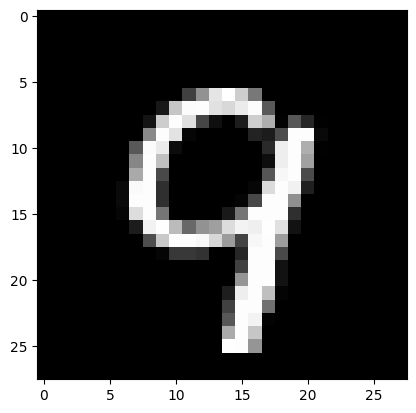

In [6]:
# Randomly check if dataset that I created are filled correctly
num = int(random.uniform(0,20))
print(num)
plt.imshow(data_high_test[num], cmap="gray") # Import the image
print(label_high_test[num])
plt.show() # Plot the image

## Data preprocessing

In [7]:
# Image dimensions
img_rows, img_cols = 28, 28

# Data formatting
if K.image_data_format() == 'channels_first':
    data_low_train  = data_low_train.reshape(data_low_train.shape[0], 1, img_rows, img_cols)
    data_high_train = data_high_train.reshape(data_high_train.shape[0], 1, img_rows, img_cols)
    data_low_test   = data_low_test.reshape(data_low_test.shape[0], 1, img_rows, img_cols)
    data_high_test  = data_high_test.reshape(data_high_test.shape[0], 1, img_rows, img_cols)
    input_shape     = (1, img_rows, img_cols)
else:
    data_low_train  = data_low_train.reshape(data_low_train.shape[0], img_rows, img_cols, 1)
    data_high_train = data_high_train.reshape(data_high_train.shape[0], img_rows, img_cols, 1)
    data_low_test   = data_low_test.reshape(data_low_test.shape[0], img_rows, img_cols, 1)
    data_high_test  = data_high_test.reshape(data_high_test.shape[0], img_rows, img_cols, 1)
    input_shape     = (img_rows, img_cols, 1)

# Normalization
data_low_train  = data_low_train.astype(np.float32) / 255.0
data_high_train = data_high_train.astype(np.float32) / 255.0
data_low_test   = data_low_test.astype(np.float32) / 255.0
data_high_test  = data_high_test.astype(np.float32) / 255.0


Normalize the dataset

## **BUILD THE MODEL**

In [8]:
# Options

# Model 
TRAIN_MODEL_1 = True
TRAIN_MODEL_2 = False
TRAIN_MODEL_3 = False

# Training options
batch_size = 32
epochs     = 10
validation_split = 0.1
optimizer  = "adam"
loss       = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics    = ['accuracy']

In [9]:
if(TRAIN_MODEL_1):
    model = Sequential()
    
    model.add(Conv2D(8, kernel_size=(3,3), activation='relu',input_shape=input_shape))
    model.add(Conv2D(8, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(32, (3,3), activation='relu'))
    model.add(Conv2D(32, (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))


    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(6,activation='softmax'))

    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 8)         80        
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 8)         584       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 8)        0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 32)        2336      
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 32)          9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 32)         0         
 2D)                                                    

2022-10-18 00:56:47.015131: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
#if(TRAIN_MODEL_1):
#    tf.keras.utils.plot_model(model, show_shapes=True, to_file='naive_inception_module.png')

In [11]:
# METHOD 2
# This model is a bit larger and should be much more precise in the feature extraction
if(TRAIN_MODEL_2):
    model2 = Sequential()
    model2.add(Conv2D(32, (3, 3), input_shape = input_shape))
    model2.add(Conv2D(32, (3, 3), activation = "relu"))
    model2.add(MaxPooling2D(pool_size = (2, 2)))
    model2.add(Dropout(0.2))
    model2.add(Flatten())
    model2.add(Dense(128, activation = "relu"))
    model2.add(Dropout(0.2))
    model2.add(Dense(6, activation = "softmax"))

    model2.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
    model2.summary()

In [12]:
if(TRAIN_MODEL_3):

    l = tf.keras.layers # syntax shortcut

    def fire(x, squeeze, expand):
        y = l.Conv2D(filters=squeeze, kernel_size=1, padding='same', activation='relu')(x)
        y1 = l.Conv2D(filters=expand//2, kernel_size=1, padding='same', activation='relu')(y)
        y3 = l.Conv2D(filters=expand//2, kernel_size=3, padding='same', activation='relu')(y)
        return tf.keras.layers.concatenate([y1, y3])

    # this is to make it behave similarly to other Keras layers
    def fire_module(squeeze, expand):
        return lambda x: fire(x, squeeze, expand)

    # usage:
    x = tf.keras.layers.Input(shape=[*input_shape]) # input is 192x192 pixels RGB

    y = tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu')(x)
    y = fire_module(24, 48)(y)
    y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
    y = fire_module(24, 48)(y)
    y = tf.keras.layers.MaxPooling2D(pool_size=2)(y)
    y = fire_module(24, 48)(y)
    y = tf.keras.layers.GlobalAveragePooling2D()(y)
    y = tf.keras.layers.Dense(6, activation='softmax')(y)

    model3 = tf.keras.Model(x, y)
    model3.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
    model3.summary()

## TRAIN THE MODEL

In [13]:
if(TRAIN_MODEL_1):
    
    labels_prova = keras.utils.to_categorical(label_low_train, len(low_set))

    train_hist = model.fit(data_low_train, label_low_train, epochs = epochs, batch_size = batch_size, validation_split = validation_split)
    
  # Evaluate the model performance
    test_loss, test_acc = model.evaluate(data_low_test, label_low_test)

    print('\nTest accuracy:', test_acc)   # Print out the model accuracy 

Epoch 1/10


/Users/andrea/Documents/VS Code/MachineLearning/venv/lib/python3.10/site-packages/keras/backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1013/1013 [==============================] - 13s 13ms/step - loss: 0.1452 - accuracy: 0.9514 - val_loss: 0.0406 - val_accuracy: 0.9903
Epoch 2/10
1013/1013 [==============================] - 13s 13ms/step - loss: 0.0434 - accuracy: 0.9859 - val_loss: 0.0289 - val_accuracy: 0.9947
Epoch 3/10
1013/1013 [==============================] - 12s 12ms/step - loss: 0.0308 - accuracy: 0.9907 - val_loss: 0.0288 - val_accuracy: 0.9933
Epoch 4/10
1013/1013 [==============================] - 12s 11ms/step - loss: 0.0254 - accuracy: 0.9923 - val_loss: 0.0206 - val_accuracy: 0.9953
Epoch 5/10
1013/1013 [==============================] - 12s 11ms/step - loss: 0.0202 - accuracy: 0.9936 - val_loss: 0.0243 - val_accuracy: 0.9936
Epoch 6/10
1013/1013 [==============================] - 12s 12ms/step - loss: 0.0174 - accuracy: 0.9946 - val_loss: 0.0196 - val_accuracy: 0.9958
Epoch 7/10
1013/1013 [==============================] - 12s 12ms/step - loss: 0.0151 - accuracy: 0.9951 - val_loss: 0.0220 - val_accura

In [14]:
if(TRAIN_MODEL_2):

    labels_prova = keras.utils.to_categorical(label_low_train, 6)

    model2.fit(data_low_train, labels_prova, epochs = epochs, batch_size = batch_size, validation_split = validation_split )

    # Evaluate the model performance
    test_loss, test_acc = model2.evaluate(data_low_test, keras.utils.to_categorical(label_low_test, 6))

    print('\nTest accuracy:', test_acc)   # Print out the model accuracy 

In [15]:
if(TRAIN_MODEL_3):
    
    labels_modified_test = keras.utils.to_categorical(label_low_train, 6)
    
    model3.fit(data_low_train, labels_modified_test, epochs = epochs, batch_size = batch_size, validation_split = validation_split)

    # Evaluate the model performance
    test_loss, test_acc = model3.evaluate(data_low_test, keras.utils.to_categorical(label_low_test, 6))

    print('\nTest accuracy:', test_acc)   # Print out the model accuracy 

## TEST THE MODEL

In [16]:
#confusion_matrix = testing(data_low_test, label_low_test, model)
#hostiry_training_plot(train_hist)
#plot_Accuracy(confusion_matrix)
#plot_ConfusionMatrix(confusion_matrix)
#plot_Table(confusion_matrix)

In [17]:
if(TRAIN_MODEL_1):
    model_test = model
elif(TRAIN_MODEL_2):
    model_test = model2
elif(TRAIN_MODEL_3):
    model_test = model3

In [18]:
predictions = model_test.predict(data_low_test)   # Make prediction of entire dataset

2/2 [==============================] - 0s 7ms/step


Prediction =  4
True label =  4


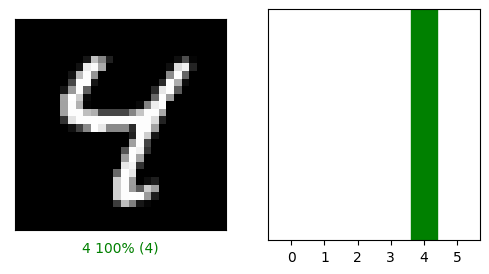

In [19]:
num = int(random.uniform(0, predictions.shape[0])) 

print("Prediction = " , np.argmax(predictions[num]))
print("True label = " , int(label_low_test[num]))

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)

plot_image(num, predictions[num], label_low_test, data_low_test)
plt.subplot(1,2,2)

plot_value_array(num, predictions[num], label_low_test)
plt.show()

# **SAVE MODELS, WEIGHTS AND FEATURES**

### SAVE THE ORIGINAL MODEL

In [20]:
ROOT_PATH = os.path.abspath('')
SAVE_MODEL_PATH = ROOT_PATH + "/Models"

ORIGINAL_MODEL_PATH = SAVE_MODEL_PATH + "/Original_model/" 

print('Test loss:', test_loss)
print('Test accuracy:', test_acc)
print('Save ORIGINAL MODEL as mnist_cnn.h5')
model_test.save(ORIGINAL_MODEL_PATH + "mnist_cnn.h5")

info = save_info(batch_size, epochs, metrics, optimizer, "SparseCategoricalCrossentropy")
save_summary_model(model_test, ORIGINAL_MODEL_PATH, info, "original")

Test loss: 0.0004847217642236501
Test accuracy: 1.0
Save ORIGINAL MODEL as mnist_cnn.h5


Now create the frozen model version for the one just saved. Which means just to cut away the last layer and save the model without the kast kayer. This should be instead saved in a txt/library file.

### SAVE THE FROZEN MODEL

In [21]:
# CREATE AND SAVE THE FROZEN MODEL
frozen_model = keras.models.Sequential(model_test.layers[:-1])
frozen_model.summary()
frozen_model.compile()

FROZEN_MODEL_PATH = SAVE_MODEL_PATH + "/Frozen_model/"

print('Save FROZEN MODEL model as mnist_cnn.h5')
info = save_info(batch_size, epochs, metrics, optimizer, "SparseCategoricalCrossentropy")
frozen_model.save(FROZEN_MODEL_PATH + "mnist_cnn.h5")
save_summary_model(frozen_model, FROZEN_MODEL_PATH, info, "frozen")



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 8)         80        
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 8)         584       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 8)        0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 32)        2336      
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 32)          9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 32)         0         
 2D)                                                  

### SAVE LL WEIGHTS (Last Layer)

Now save also the last layer weights in a txt file, this will later be used in the OpenMV camera for loading the weights that have been already trained. (ll = last layer)

In [22]:
ll_weights = np.array(model_test.layers[-1].get_weights()[0])   # get last layer weights from TF model
ll_biases  = np.array(model_test.layers[-1].get_weights()[1])   # get last layer biases from TF model
print(f'The shape of the last layer weights is: {ll_weights.shape}')
print(f'The shape of the last layer biases is: {ll_biases.shape}')

# -------- WEIGHTS
# NB: the filof weights is separated in smaller rows (338 float values on each row)
# thjis is done in order to make it easier for the OpenMV camera to load each line (memory problems)
with open(FROZEN_MODEL_PATH + 'll_weights.txt', 'w') as new_file:

    for j in range(0, ll_weights.shape[1]):
        for i in range(0, ll_weights.shape[0]): 
            if(i%338==0 and i!= 0 and i != ll_weights.shape[0]-1):
                new_file.write('\n')
                
            new_file.write(str(ll_weights[i,j]))
            
            if(i == ll_weights.shape[0]-1):
                new_file.write('\n')
            elif((i+1)%338 == 0):
                dummy = 0
            else:
                new_file.write(',')

new_file.close()


# -------- BIASES
with open(FROZEN_MODEL_PATH + 'll_biases.txt', 'w') as new_file:

    for i in range(0, ll_biases.shape[0]):     
        new_file.write(str(ll_biases[i])) 
        if(i!=ll_biases.shape[0]-1):
            new_file.write(',')
new_file.close()

The shape of the last layer weights is: (512, 6)
The shape of the last layer biases is: (6,)


### SAVE FEATURES

In [23]:
data_test = np.concatenate((data_low_test, data_high_test))
label_test = np.concatenate((label_low_test, label_high_test))

# Compute predictions
features = frozen_model.predict(data_test, verbose = False)

if(n_elem_low == n_elem_high):
  n_elem = str(n_elem_low)
else:
  n_elem = str(n_elem_low) + '_' + str(n_elem_high)

np.savetxt(ORIGINAL_MODEL_PATH +'/'+'ll_features_'+ n_elem + '.txt',features, fmt='%.3f')

with open(ORIGINAL_MODEL_PATH +'/'+'ll_features_'+ n_elem + '.txt', 'w') as new_file:

    for i in range(0, features.shape[0]):
        for j in range(0, features.shape[1]): 
            if features[i,j] != 0:
              str1 = '%.3f '%features[i,j]
            else:
              str1 = '0 '

            new_file.write(str1)
            
        new_file.write('\n')     

new_file.close()

np.savetxt(ORIGINAL_MODEL_PATH +'/'+'ll_labels_features_'+ n_elem + '.txt',label_test, fmt='%1d')

# Pruning

In [24]:
from tensorflow.keras.models import load_model
import tensorflow_model_optimization as tfmot


####
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after n epochs.
batch_size = 32
epochs = 5
validation_split = 0.1  # 10% of training set will be used for validation set. 

num_images = data_low_train.shape[0] * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}


model_for_pruning = prune_low_magnitude(model_test, **pruning_params)

# `prune_low_magnitude` requires a recompile.

# Select appropriate optimizer
model_for_pruning.compile(optimizer='adam',
                          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                          metrics=['accuracy'])

model_for_pruning.summary()




#####
logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

model_for_pruning.fit(data_low_train, label_low_train,
                    batch_size=batch_size, epochs=epochs, validation_split=validation_split, callbacks=callbacks)



####
_, model_for_pruning_accuracy = model_for_pruning.evaluate(data_low_test, label_low_test, verbose=0)

print('Original test accuracy: ', test_acc)
print('Pruned test accuracy:   ', model_for_pruning_accuracy)


####
# First, create a compressible model for TensorFlow

PRUNED_MODEL_PATH = SAVE_MODEL_PATH + "/Pruned_model"


model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)
model_for_export.save(PRUNED_MODEL_PATH + '/OMV_Pruned_cnn.h5', include_optimizer=False)




#####
# Then, create a compressible model for TFLite

converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
pruned_tflite_model = converter.convert()

with open(PRUNED_MODEL_PATH + '/OMV_Pruned_cnn.tflite', 'wb') as f:
    f.write(pruned_tflite_model)


#####
print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(FROZEN_MODEL_PATH + "mnist_cnn.h5")))
print("Size of gzipped pruned Keras model  : %.2f bytes" % (get_gzipped_model_size(PRUNED_MODEL_PATH + '/OMV_Pruned_cnn.h5')))
print("Size of gzipped pruned TFlite model : %.2f bytes" % (get_gzipped_model_size(PRUNED_MODEL_PATH + '/OMV_Pruned_cnn.tflite')))




#####
frozen_pruned_model = keras.models.Sequential(model_for_pruning.layers[:-1])
frozen_pruned_model.summary()
frozen_pruned_model.compile()

FROZEN_PRUNED_MODEL_PATH = SAVE_MODEL_PATH + "/Frozen_Pruned_model"

print('Save FROZEN PRUNED MODEL model as OMV_Frozen_pruned_cnn.h5')
frozen_pruned_model.save(FROZEN_PRUNED_MODEL_PATH + "OMV_Frozen_pruned_cnn.h5")
info = save_info(batch_size, epochs, metrics, optimizer, "SparseCategoricalCrossentropy")
save_summary_model(frozen_pruned_model, FROZEN_PRUNED_MODEL_PATH, info, 'frozen')




#####
model_for_export2 = tfmot.sparsity.keras.strip_pruning(frozen_pruned_model)
model_for_export2.save(PRUNED_MODEL_PATH + '/OMV_Frozen_pruned_cnn.h5', include_optimizer=False)




###
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export2)
pruned_tflite_fmodel = converter.convert()

with open(PRUNED_MODEL_PATH + '/OMV_Pruned_cnn.tflite', 'wb') as f:
    f.write(pruned_tflite_fmodel)



####
data_test = np.concatenate((data_low_test, data_high_test))
label_test = np.concatenate((label_low_test, label_high_test))
features = frozen_pruned_model.predict(data_test)




####
count = 0

for i in range(0, len(features[:,1])):
  for j in range(0, len(features[1,:])):
    if features[i,j] == 0:
      count +=1

print(count/len(features[:,1])/len(features[1,:])*100)




######

np.savetxt(FROZEN_PRUNED_MODEL_PATH +'/'+'ll_features_p_10.txt',features, fmt='%.3f')

with open(FROZEN_PRUNED_MODEL_PATH +'/'+'ll_features_p_10.txt', 'w') as new_file:

    for i in range(0, features.shape[0]):
        for j in range(0, features.shape[1]): 
            if features[i,j] != 0:
              str1 = '%.3f '%features[i,j]
            else:
              str1 = '0 '

            new_file.write(str1)
            
        new_file.write('\n')     

new_file.close()

np.savetxt(FROZEN_PRUNED_MODEL_PATH +'/'+'ll_labels_features_p_10.txt',label_test, fmt='%1d')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d   (None, 26, 26, 8)        154       
 (PruneLowMagnitude)                                             
                                                                 
 prune_low_magnitude_conv2d_  (None, 24, 24, 8)        1162      
 1 (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_max_poo  (None, 12, 12, 8)        1         
 ling2d (PruneLowMagnitude)                                      
                                                                 
 prune_low_magnitude_conv2d_  (None, 10, 10, 32)       4642      
 2 (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_conv2d_  (None, 8, 8, 32)         1

KeyboardInterrupt: 

Tflite frozen pruned